<a href="https://colab.research.google.com/github/ArtemAvanesov/Roonyx-Labs/blob/master/5_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read and unzip data

In [0]:
base_dir = '/content/drive/My Drive/Colab/Roonyx/work_5'
zip_path = base_dir + '/leaf_diseases.zip'
unzip_path = base_dir + '/dataset'

!mkdir '$unzip_path'
!unzip -d '$unzip_path' '$zip_path'

# Plotting class distribution histogram

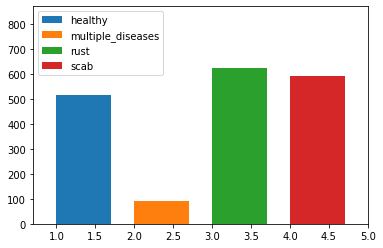

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

leafs = pd.read_csv(unzip_path+'/plant-pathology-2020-fgvc7/train.csv') 
y = np.array(leafs.drop(["image_id"], axis=1).values)

num_healthy = sum(y[:,0])
num_multiple_diseases = sum(y[:,1])
num_rust = sum(y[:,2])
num_scab = sum(y[:,3])

plt.hist([1]*num_healthy,bins=4, label = "healthy", width = 0.7)
plt.hist([2]*num_multiple_diseases,bins=4, label = "multiple_diseases", width = 0.7)
plt.hist([3]*num_rust,bins=4, label = "rust", width = 0.7)
plt.hist([4]*num_scab,bins=4, label = "scab", width = 0.7)
plt.ylim(0,max(num_healthy,num_multiple_diseases,num_rust, num_scab)*1.4)
plt.xlim(0.7,5)
plt.legend(loc='best')

# Splitting data

## Creating directories for train, test, validation

In [0]:
import os

splitted_dataset_path = base_dir + '/splitted_dataset'
os.mkdir(splitted_dataset_path)

train_dir = os.path.join(splitted_dataset_path, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(splitted_dataset_path, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(splitted_dataset_path, 'test')
os.mkdir(test_dir)

for path in [train_dir, test_dir, validation_dir]:
  for num_class in [0,1,2,3]:
    class_dir = os.path.join(path, str(num_class) + '_class')
    os.mkdir(class_dir)

## Search image indexes for each class

In [0]:
indices_class_0, indices_class_1, indices_class_2, indices_class_3 = [], [], [], []
for i in range(0, len(y),1):
  if(np.argmax(y[i]) == 0):
    indices_class_0.append(i)
  elif(np.argmax(y[i]) == 1):
    indices_class_1.append(i)
  elif(np.argmax(y[i]) == 2):
    indices_class_2.append(i)
  elif(np.argmax(y[i]) == 3):
    indices_class_3.append(i)

## Shuffling Index Arrays

In [0]:
from tensorflow.random import set_seed
import random

seed = 42
np.random.seed(seed)
set_seed(seed)

random.shuffle(indices_class_0)
random.shuffle(indices_class_1)
random.shuffle(indices_class_2)
random.shuffle(indices_class_3)

indices_classes = [indices_class_0, indices_class_1, indices_class_2, indices_class_3]

## Calculation num of elements in test, train and validation samples

In [58]:
import pandas as pd

percent_validation = 15
percent_test = 15

num_test = []
num_validation = []
num_train = []
for i in range(0,4,1):
  num_test.append(int(len(indices_classes[i])*percent_test/100))
  num_validation.append(int(len(indices_classes[i])*percent_validation/100))
  num_train.append(len(indices_classes[i])-num_test[-1] - num_validation[-1])

array_for_pandas = np.transpose([num_train, num_validation, num_test])

df = pd.DataFrame({
     '': ['Train', 'Validation', 'Test'],
     'Class 0': array_for_pandas[0,:],
     'Class 1': array_for_pandas[1,:],
     'Class 2': array_for_pandas[2,:],
     'Class 3': array_for_pandas[3,:]
 })

df

,,Class 0,Class 1,Class 2,Class 3
0,Train,362,65,436,416
1,Validation,77,13,93,88
2,Test,77,13,93,88


## Writing data with train, test and validation samples

In [0]:
import shutil

src = unzip_path + '/plant-pathology-2020-fgvc7/images'

# For test images
for num_class in [0,1,2,3]:
  test_fnames = ['Train_{}.jpg'.format(i) for i in indices_classes[num_class][0:num_test[num_class]]]
  for fname in test_fnames:
    shutil.copyfile(src+'/'+fname, test_dir+'/'+str(num_class)+'_class'+'/'+fname)

# For validation images 
for num_class in [0,1,2,3]:
  validation_fnames = ['Train_{}.jpg'.format(i) for i in indices_classes[num_class][num_test[num_class]:num_test[num_class] + num_validation[num_class]]]
  for fname in validation_fnames:
    shutil.copyfile(src+'/'+fname, validation_dir+'/'+str(num_class)+'_class'+'/'+fname)

# For train images
for num_class in [0,1,2,3]:
  train_fnames = ['Train_{}.jpg'.format(i) for i in indices_classes[num_class][num_test[num_class] + num_validation[num_class]:]]
  for fname in train_fnames:
    shutil.copyfile(src+'/'+fname, train_dir+'/'+str(num_class)+'_class'+'/'+fname)

# Preprocessing data

In [60]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=100,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=100,
        class_mode='categorical')

test_generator=test_datagen.flow_from_directory(
        test_dir,
        target_size=(150,150),
        batch_size=100,
        class_mode='categorical')

Found 1279 images belonging to 4 classes.
Found 271 images belonging to 4 classes.
Found 271 images belonging to 4 classes.


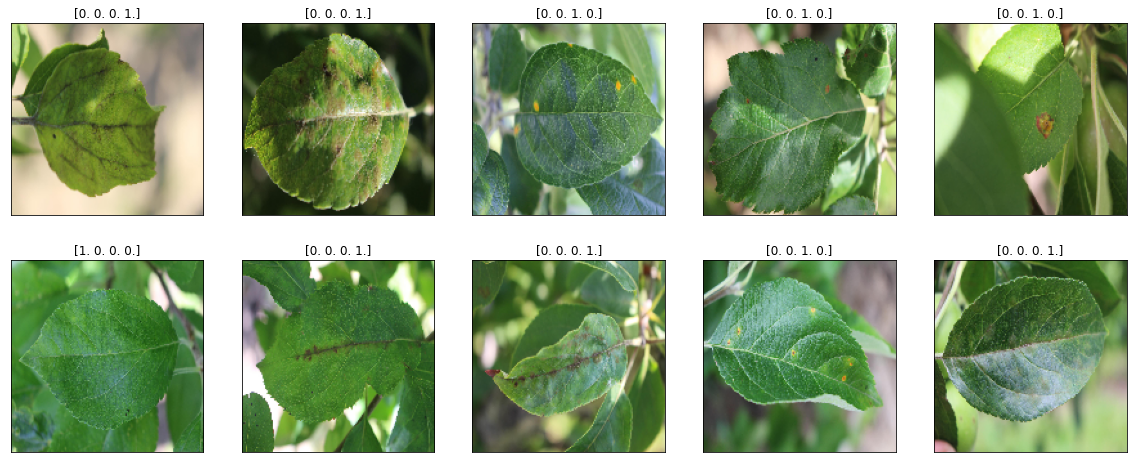

In [61]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

imgs,labels = train_generator.next()

fix,axes = plt.subplots(2,5, figsize=(20,8), subplot_kw={'xticks':(),'yticks':()})
for target, image, ax in zip(labels[:10], imgs[:10], axes.ravel()):
    ax.imshow(image, cmap=plt.cm.binary)
    ax.set_title(target)

# Model of Convolutional Neural Network


In [0]:
from keras import layers
from keras import models
from keras.layers import Dropout

def my_net(dropout=False , dropout_value = 0.0):

  model = models.Sequential()

  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  if dropout:
    model.add(Dropout(dropout_value))

  model.add(layers.Conv2D(16, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  if dropout:
    model.add(Dropout(dropout_value))

  model.add(layers.Conv2D(8, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  if dropout:
    model.add(Dropout(dropout_value))

  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(4, activation='softmax'))

  return model

# Neural network without dropout

In [72]:
model = my_net()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 16)        4624      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 8)         1160      
_________________________________________________________________
flatten_5 (Flatten)          (None, 9248)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)               

## Neural network training

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
              train_generator,
              steps_per_epoch=sum(num_train)//100,
              epochs=30,
              validation_data=validation_generator,
              validation_steps=sum(num_validation)//100)

## Accuracy and loss

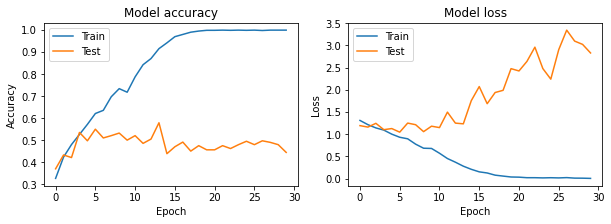

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Neural network with dropout

In [84]:
model_array = []
dropout_array = [0.5, 0.6, 0.7]
for dropout_value in dropout_array:
  model_array.append(my_net(dropout=True, dropout_value=dropout_value))

model_array[0].summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 72, 72, 16)        4624      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 36, 36, 16)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 34, 34, 8)       

## Neural network training

In [0]:
history_array = []
for model_nn in model_array:
  model_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  history_array.append(model_nn.fit(
                train_generator,
                steps_per_epoch=sum(num_train)//100,
                epochs=10,
                validation_data=validation_generator,
                validation_steps=sum(num_validation)//100))

## Accuracy and loss

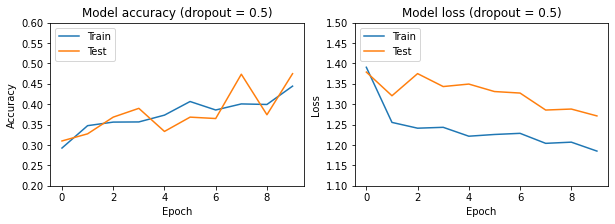

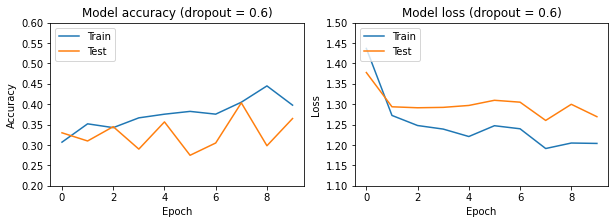

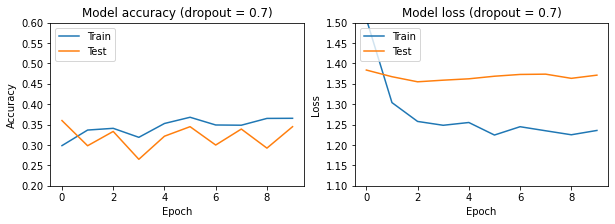

In [108]:
import matplotlib.pyplot as plt

for i in range (0,len(history_array),1):

  plt.figure(figsize=(10,3))

  plt.subplot(1, 2, 1)
  plt.plot(history_array[i].history['accuracy'])
  plt.plot(history_array[i].history['val_accuracy'])
  plt.title('Model accuracy (dropout = {})'.format(dropout_array[i]))
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.ylim(0.2,0.6)
  plt.legend(['Train', 'Test'], loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(history_array[i].history['loss'])
  plt.plot(history_array[i].history['val_loss'])
  plt.title('Model loss (dropout = {})'.format(dropout_array[i]))
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.ylim(1.1,1.5)
  plt.legend(['Train', 'Test'], loc='upper left')

# Metrics on the best model

In [126]:
index_best_model = 2

preds = np.array([])
y_true = np.array([])

from sklearn.metrics import classification_report

for _ in range(len(test_generator)):
  images, labels = test_generator.next()
  pred = model_array[index_best_model].predict(images)
  preds = np.concatenate((preds, np.argmax(pred, axis=1)))
  y_true = np.concatenate((y_true, np.argmax(labels, axis=1)))

print(classification_report(y_true, preds, target_names=['healthy', 'multiple_diseases', 'rust', 'scab']))

                   precision    recall  f1-score   support

          healthy       0.31      0.52      0.39        77
multiple_diseases       0.00      0.00      0.00        13
             rust       0.00      0.00      0.00        93
             scab       0.35      0.57      0.44        88

         accuracy                           0.33       271
        macro avg       0.17      0.27      0.21       271
     weighted avg       0.20      0.33      0.25       271



# Feature maps of the best model

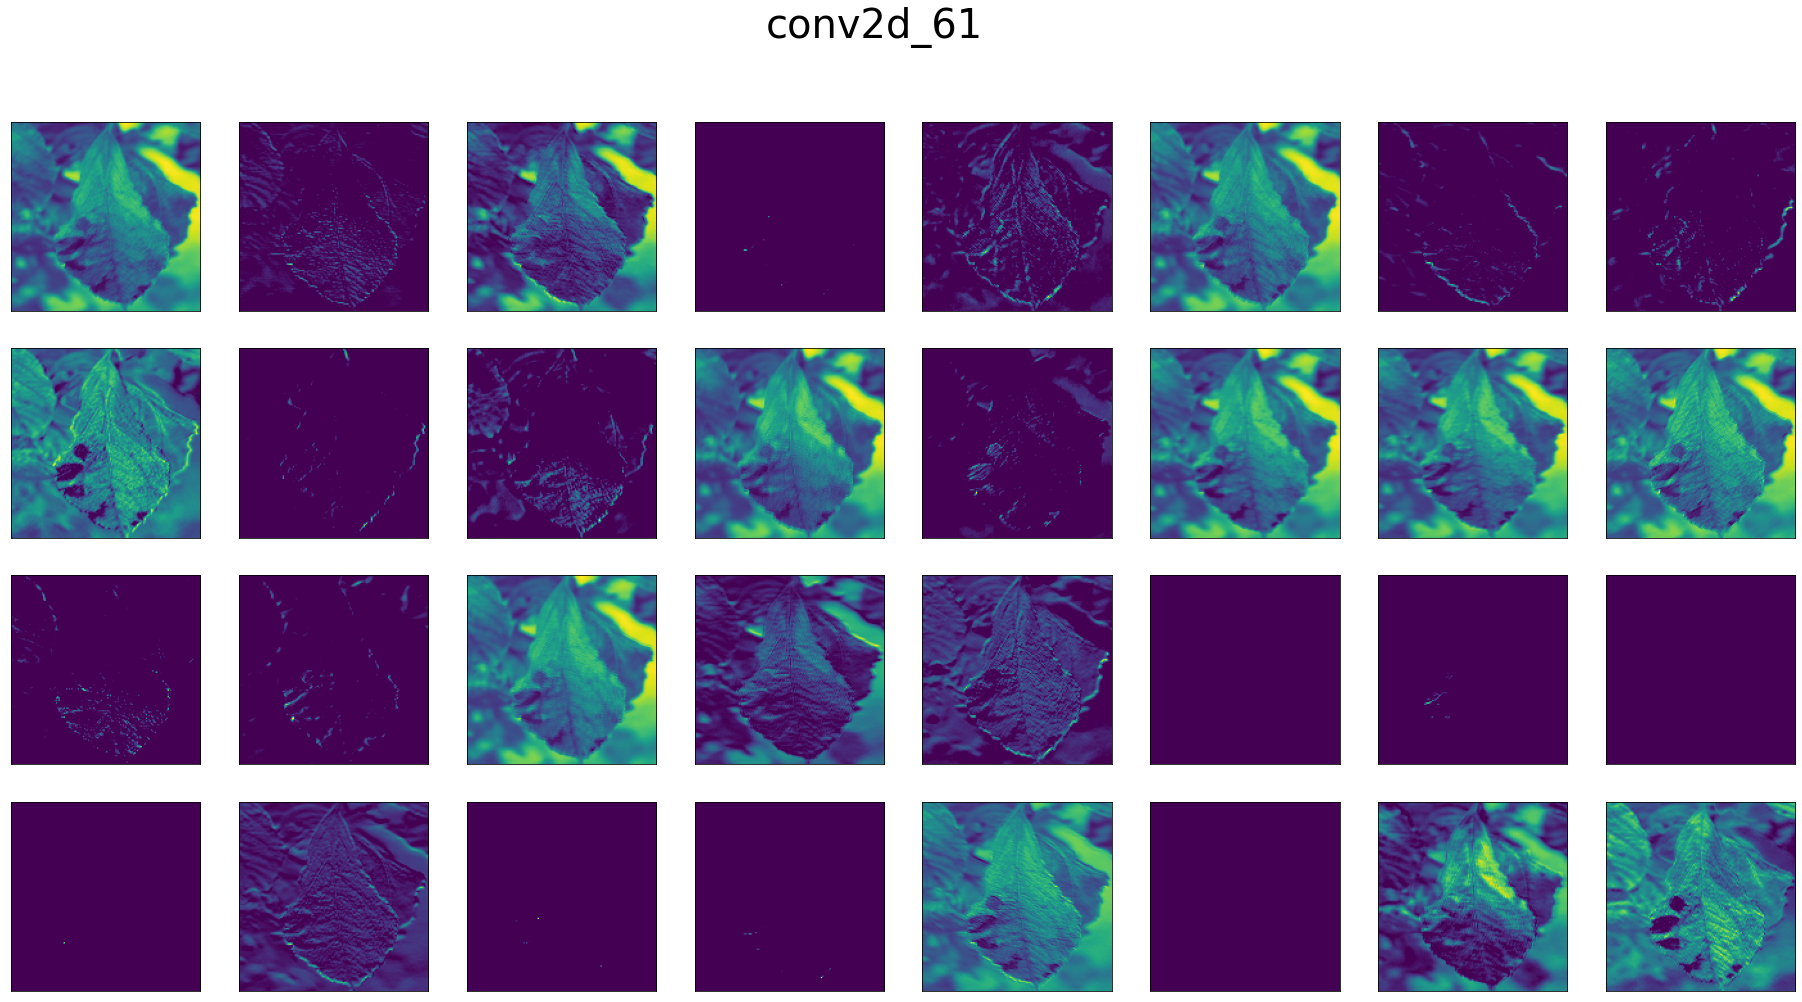

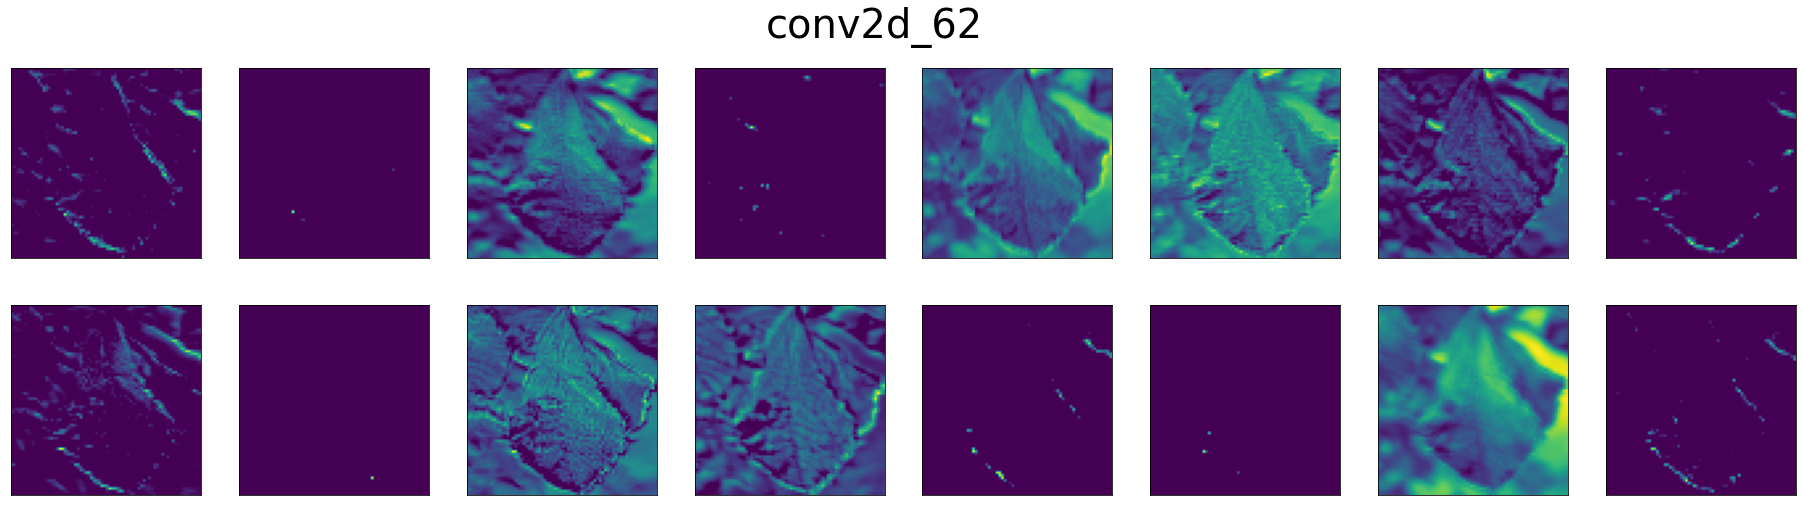

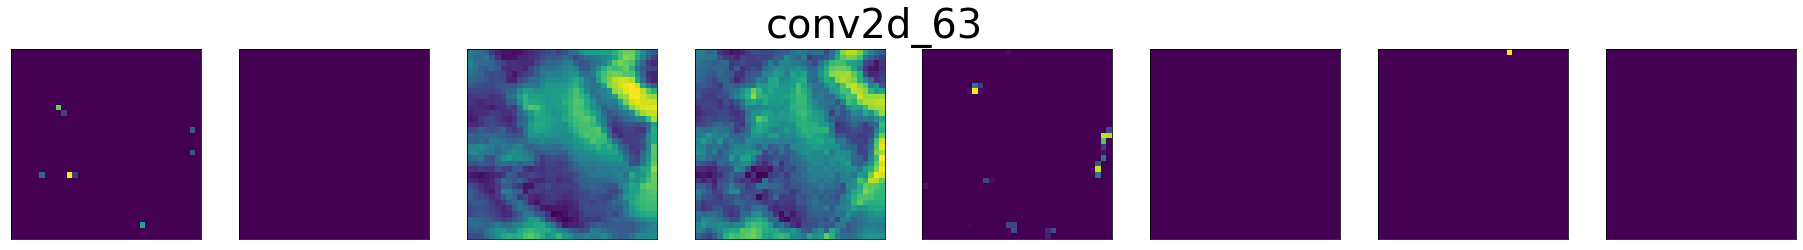

In [129]:
from keras.models import Model

imgs,labels = train_generator.next()
img = imgs[:1]

num_in_row = 8

names = []
outputs = []

for layer in model_array[index_best_model].layers:
  if 'conv' in layer.name:
    outputs.append(layer.output)
    names.append(layer.name)

layers_names = [model_array[index_best_model].layers[i].name for i in ixs]
model2 = Model(inputs = model_array[2].inputs, outputs=outputs)

feature_maps = model2.predict(img)
for feature_maps, l_name in zip(feature_maps, names):
  fmap = np.transpose(feature_maps[0], axes = [2,1,0])
  fig, axes = plt.subplots(int(len(fmap)/num_in_row), num_in_row, figsize = (32, 4*int(len(fmap)/num_in_row)), subplot_kw={'xticks':(), 'yticks':()})
  fig.suptitle(l_name, fontsize = 40)

  for image, ax in zip(fmap, axes.ravel()):
    ax.imshow(image)